# Retail Outlet Segmentation

**Goal:** Cluster retail outlets into actionable personas to optimize inventory, assortment, and promotions. 


In [25]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.impute import SimpleImputer

# display settings
pd.options.display.max_columns = 200
pd.options.display.width = 160



In [26]:
# Load dataset
data=pd.read_csv("blinkit_data.csv")
df = data.copy()
print("Dataset shape:", df.shape)
df.head(5)


Dataset shape: (8523, 12)


,Item Fat Content,Item Identifier,Item Type,Outlet Establishment Year,Outlet Identifier,Outlet Location Type,Outlet Size,Outlet Type,Item Visibility,Item Weight,Sales,Rating
0,Regular,FDX32,Fruits and Vegetables,2012,OUT049,Tier 1,Medium,Supermarket Type1,0.100014,15.10,145.4786,5.0
1,Low Fat,NCB42,Health and Hygiene,2022,OUT018,Tier 3,Medium,Supermarket Type2,0.008596,11.80,115.3492,5.0
2,Regular,FDR28,Frozen Foods,2010,OUT046,Tier 1,Small,Supermarket Type1,0.025896,13.85,165.0210,5.0
3,Regular,FDL50,Canned,2000,OUT013,Tier 3,High,Supermarket Type1,0.042278,12.15,126.5046,5.0
4,Low Fat,DRI25,Soft Drinks,2015,OUT045,Tier 2,Small,Supermarket Type1,0.033970,19.60,55.1614,5.0


In [27]:
# Quick column inspection
for c in df.columns:
    print("-", c)
df.describe(include='all').T


- Item Fat Content
- Item Identifier
- Item Type
- Outlet Establishment Year
- Outlet Identifier
- Outlet Location Type
- Outlet Size
- Outlet Type
- Item Visibility
- Item Weight
- Sales
- Rating


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Item Fat Content,8523,5,Low Fat,5089,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Item Identifier,8523,1559,FDW13,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Item Type,8523,16,Fruits and Vegetables,1232,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Outlet Establishment Year,8523.0,NaN,NaN,NaN,2010.831867,8.37176,1998.0,2000.0,2012.0,2017.0,2022.0
Outlet Identifier,8523,10,OUT027,935,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Outlet Location Type,8523,3,Tier 3,3350,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Outlet Size,8523,3,Medium,3631,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Outlet Type,8523,4,Supermarket Type1,5577,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Item Visibility,8523.0,NaN,NaN,NaN,0.066132,0.051598,0.0,0.026989,0.053931,0.094585,0.328391
Item Weight,7060.0,NaN,NaN,NaN,12.857645,4.643456,4.555,8.77375,12.6,16.85,21.35


In [28]:
# Check missing values
missing = df.isnull().sum().sort_values(ascending=False)
missing[missing>0]


Item Weight    1463
dtype: int64

In [29]:
# Example simple imputation strategy (adjust column names as needed)
# - Numeric: median
# - Categorical: fill with 'Unknown'
num_cols = df.select_dtypes(include=['number']).columns.tolist()
cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()

# Impute numeric
imp_num = SimpleImputer(strategy='median')
df[num_cols] = imp_num.fit_transform(df[num_cols])

# Fill categorical missing with 'Unknown'
df[cat_cols] = df[cat_cols].fillna('Unknown')




In [30]:
num_cols

['Outlet Establishment Year',
 'Item Visibility',
 'Item Weight',
 'Sales',
 'Rating']

In [31]:
cat_cols

['Item Fat Content',
 'Item Identifier',
 'Item Type',
 'Outlet Identifier',
 'Outlet Location Type',
 'Outlet Size',
 'Outlet Type']

# Exploratory Data Analysis (EDA)


In [32]:
# Choose numeric features for clustering. Update this list to match your dataset.
# By default we'll pick all numeric columns and then drop identifiers if present.
numeric_features = df.select_dtypes(include=['number']).columns.tolist()

# Drop obvious ID / target cols if present (update the names if different)
drop_if_exists = ['outlet_id','id','Outlet_ID','SKU_ID','sales_target']
numeric_features = [c for c in numeric_features if c not in drop_if_exists]

print('Numeric features used for clustering:', numeric_features)
X = df[numeric_features].copy()
X.head(3)


Numeric features used for clustering: ['Outlet Establishment Year', 'Item Visibility', 'Item Weight', 'Sales', 'Rating']


,Outlet Establishment Year,Item Visibility,Item Weight,Sales,Rating
0,2012.0,0.100014,15.10,145.4786,5.0
1,2022.0,0.008596,11.80,115.3492,5.0
2,2010.0,0.025896,13.85,165.0210,5.0


In [33]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print('Scaled shape:', X_scaled.shape)


Scaled shape: (8523, 5)


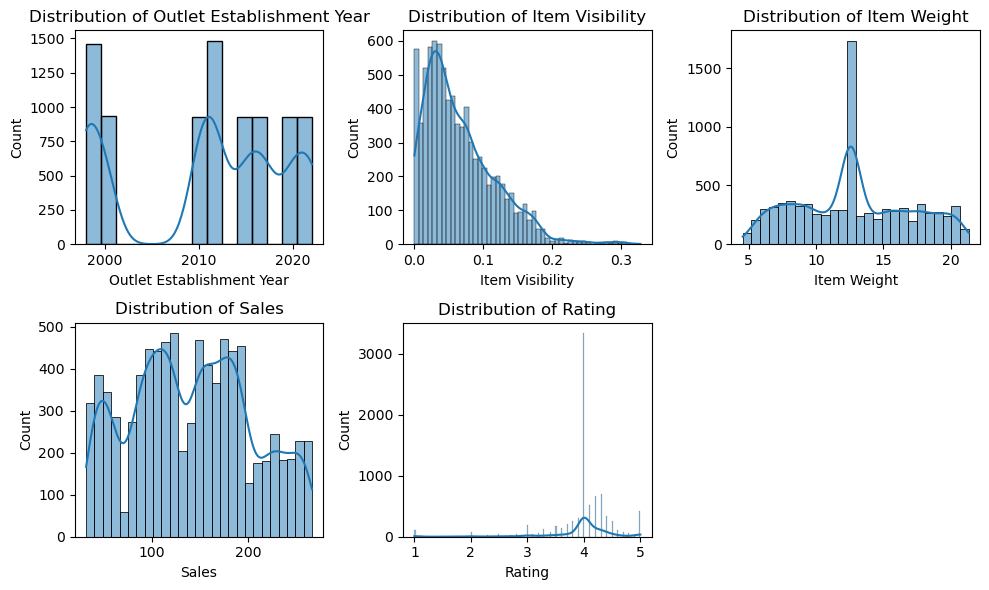

In [39]:
plt.rcParams['figure.figsize']=[10,6]
t=1
for col in num_cols:
    plt.subplot(2,3,t)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    t+=1
plt.tight_layout()
plt.show()


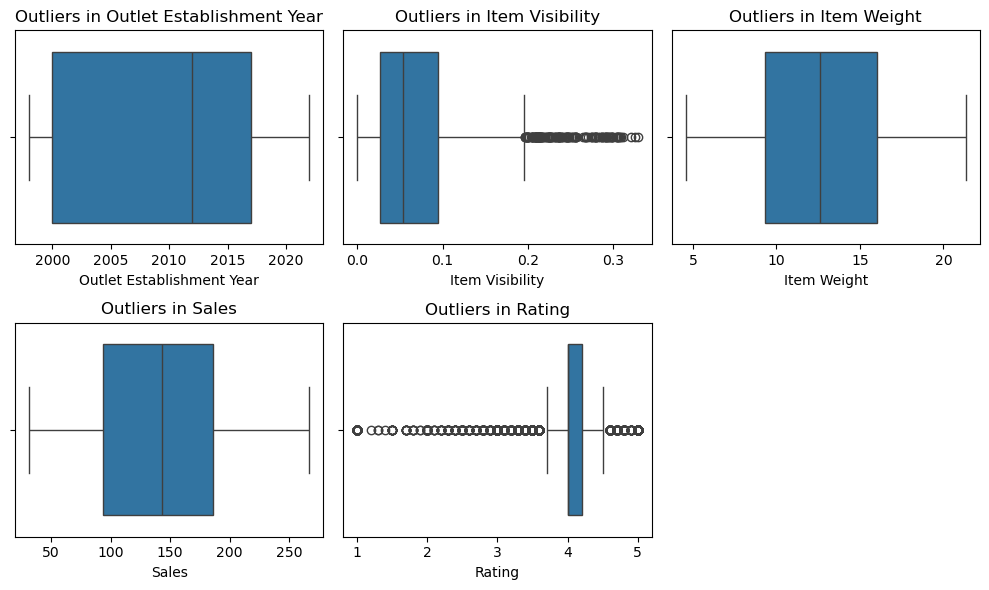

In [41]:
# Outlier detection using boxplots
t=1
for col in num_cols:
    plt.subplot(2,3,t)
    sns.boxplot(x=df[col])
    plt.title(f'Outliers in {col}')
    t+=1
plt.tight_layout()    
plt.show()


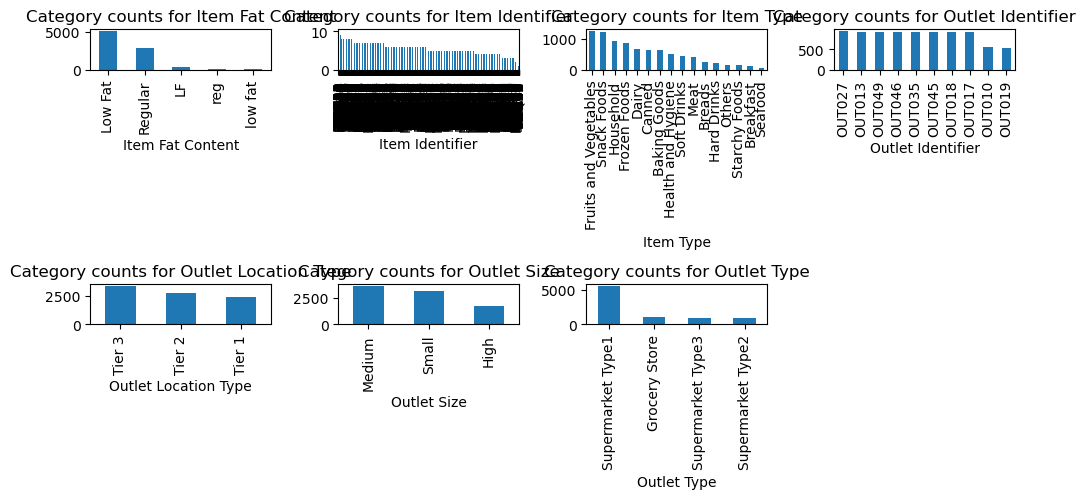

In [43]:
# Category counts
t=1
for col in cat_cols:
    plt.subplot(3,4,t)
    df[col].value_counts().plot(kind='bar')
    plt.title(f'Category counts for {col}')
    t+=1
plt.tight_layout()    
plt.show()


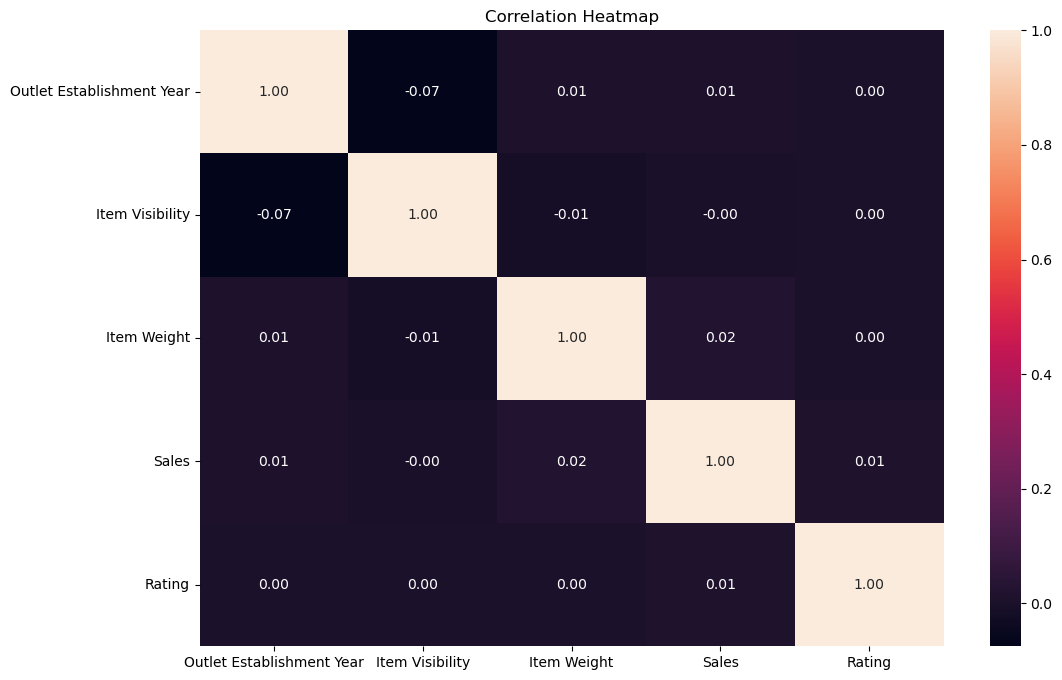

In [19]:
# Correlation heatmap
plt.figure(figsize=(12,8))
sns.heatmap(df[num_cols].corr(), annot=True, fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


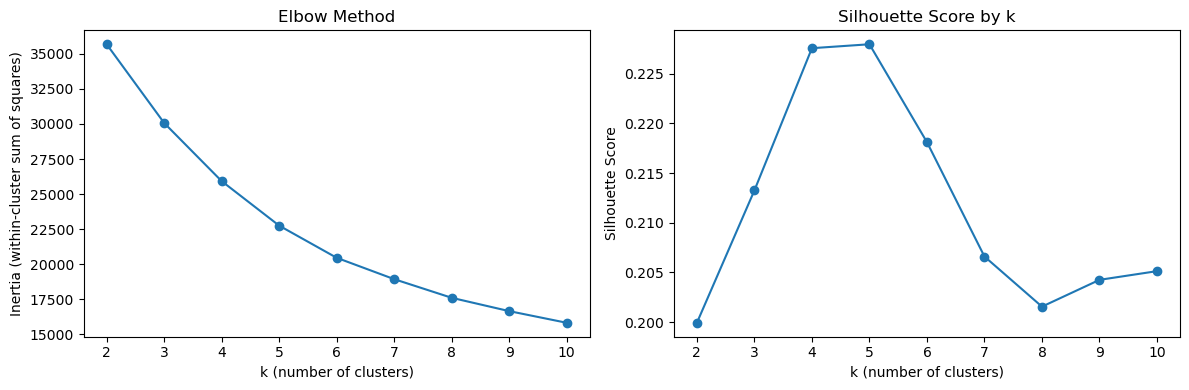

,k,inertia,silhouette
3,5,22747.601395,0.227959
2,4,25922.816376,0.227564
4,6,20454.463476,0.218106
1,3,30071.015666,0.213248
5,7,18929.689377,0.206593
8,10,15817.855609,0.205121
7,9,16649.879406,0.204245
6,8,17599.908856,0.201548
0,2,35687.984038,0.199922


In [12]:
# Elbow and Silhouette analysis to choose k
inertia = []
sil_scores = []
K = range(2,11)

for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    inertia.append(km.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))

# Plot Elbow and Silhouette
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(K, inertia, '-o')
plt.xlabel('k (number of clusters)')
plt.ylabel('Inertia (within-cluster sum of squares)')
plt.title('Elbow Method')

plt.subplot(1,2,2)
plt.plot(K, sil_scores, '-o')
plt.xlabel('k (number of clusters)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score by k')
plt.tight_layout()
plt.show()

pd.DataFrame({'k': list(K), 'inertia': inertia, 'silhouette': sil_scores}).sort_values('silhouette', ascending=False)


In [13]:
# Fit KMeans with chosen k (change k if needed)
chosen_k = 4
km = KMeans(n_clusters=chosen_k, random_state=42, n_init=50)
cluster_labels = km.fit_predict(X_scaled)

# attach cluster labels to original df
df['cluster'] = cluster_labels
print('Cluster counts:')
print(df['cluster'].value_counts().sort_index())


Cluster counts:
cluster
0     458
1    2279
2    2787
3    2999
Name: count, dtype: int64


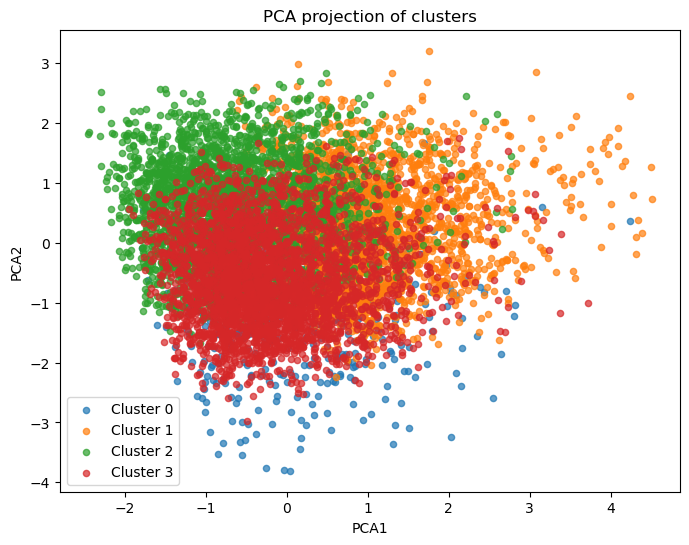

Explained variance ratio (PCA 2 components): [0.21587261 0.20493629]


In [14]:
# PCA for 2D visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
for cl in sorted(df['cluster'].unique()):
    mask = df['cluster']==cl
    plt.scatter(X_pca[mask,0], X_pca[mask,1], label=f'Cluster {cl}', s=20, alpha=0.7)
plt.xlabel('PCA1'); plt.ylabel('PCA2'); plt.title('PCA projection of clusters')
plt.legend()
plt.show()

print('Explained variance ratio (PCA 2 components):', pca.explained_variance_ratio_)


In [15]:
# Cluster centroids in original feature space (scaled back)
centroids_scaled = km.cluster_centers_
centroids = scaler.inverse_transform(centroids_scaled)
centroid_df = pd.DataFrame(centroids, columns=X.columns)
centroid_df['cluster'] = range(centroid_df.shape[0])
centroid_df.T


,0,1,2,3
Outlet Establishment Year,2011.118421,1998.770175,2015.554878,2015.567523
Item Visibility,0.064532,0.070422,0.063916,0.065174
Item Weight,12.979298,12.731958,17.042665,8.918439
Sales,137.528422,140.350073,144.176632,139.048318
Rating,2.067105,4.058465,4.087159,4.071390
cluster,0.000000,1.000000,2.000000,3.000000


In [16]:
# Quick persona summary using centroid stats and cluster sizes
summary = []
for cl in sorted(df['cluster'].unique()):
    size = (df['cluster']==cl).sum()
    row = centroid_df[centroid_df['cluster']==cl].drop('cluster',axis=1).T.squeeze()
    top_feats = row.sort_values(ascending=False).head(4)
    summary.append({'cluster':int(cl),'size':int(size),'top_features':top_feats.to_dict()})

import pprint
pprint.pprint(summary)


[{'cluster': 0,
  'size': 458,
  'top_features': {'Item Weight': 12.979298245614036,
                   'Outlet Establishment Year': 2011.1184210526317,
                   'Rating': 2.067105263157898,
                   'Sales': 137.52842192982456}},
 {'cluster': 1,
  'size': 2279,
  'top_features': {'Item Weight': 12.731958333333333,
                   'Outlet Establishment Year': 1998.7701754385964,
                   'Rating': 4.058464912280702,
                   'Sales': 140.35007324561403}},
 {'cluster': 2,
  'size': 2787,
  'top_features': {'Item Weight': 17.042664992826396,
                   'Outlet Establishment Year': 2015.5548780487804,
                   'Rating': 4.08715925394548,
                   'Sales': 144.17663156384506}},
 {'cluster': 3,
  'size': 2999,
  'top_features': {'Item Weight': 8.91843947982661,
                   'Outlet Establishment Year': 2015.5675225075024,
                   'Rating': 4.0713904634878295,
                   'Sales': 139.0483176392130

In [17]:
# Cluster evaluation metrics
sil_score = silhouette_score(X_scaled, cluster_labels)
db_score = davies_bouldin_score(X_scaled, cluster_labels)
print(f"Silhouette Score: {sil_score:.4f}")
print(f"Davies-Bouldin Score: {db_score:.4f}")


Silhouette Score: 0.2280
Davies-Bouldin Score: 1.4680


## Cluster 0 — Underperforming New Stores (Low Rating, Low Sales)

**~Why they exist:
These outlets are newer but struggling. They have heavier items but customers rate them poorly.**

* Business actions:

>Improve in-store experience & staff training

>Audit product quality (especially heavier items)

>Run discount campaigns to push sales

>Improve store layout and stocking

>Increase visibility via ads or banners

## Cluster 1 — Old, Stable High-Performers (High Rating + High Sales)

**Why they are great:
These are the OG stores. Customers trust them; they draw consistent sales.**

* Business actions:

>Introduce premium SKUs (people trust these stores)

>Target loyalty programs

>Reduce OOS (stockouts) because demand is stable

>Use these stores as pilot trial locations

## Cluster 2 — Fast-Growing Modern Outlets (High Sales, High Rating, New)

**~Why they shine:
They are newer stores but already booming. Heavy SKUs move fast here.**
* Business actions:

>Increase premium inventory

>Push festive bundle offers

>Expand shelf space for heavy/expensive items

>Promote these outlets in new marketing


## Cluster 3 — Mass-Market Average Performers (Biggest Cluster)

**~Why they matter:
Most outlets fall here — not bad, not great.**

* Business actions:
  
>Improve planogram (arrangement)

>Minor discounts to push sales up

>Targeted promotions based on local needs

>Improve efficiency to reduce operational cost

**This cluster is the backbone of your retail network.**

## Our retail outlet network naturally segments into 4 distinct personas, each requiring a different inventory, marketing, and operational strategy.

* Cluster 0 → Underperforming new stores: require quality improvement + aggressive promotions.

* Cluster 1 → Mature high performers: ideal for premium products and loyalty programs.
* Cluster 2 → Fast-growing modern stores: invest more in these outlets, high ROI potential.
* Cluster 3 → Large mass-market cluster: requires operational optimization and targeted offers.